
--- MNIST CNN Model Summary ---
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_for_analysis (Flat  (None, 1600)              0         
 ten)                                                            
                     

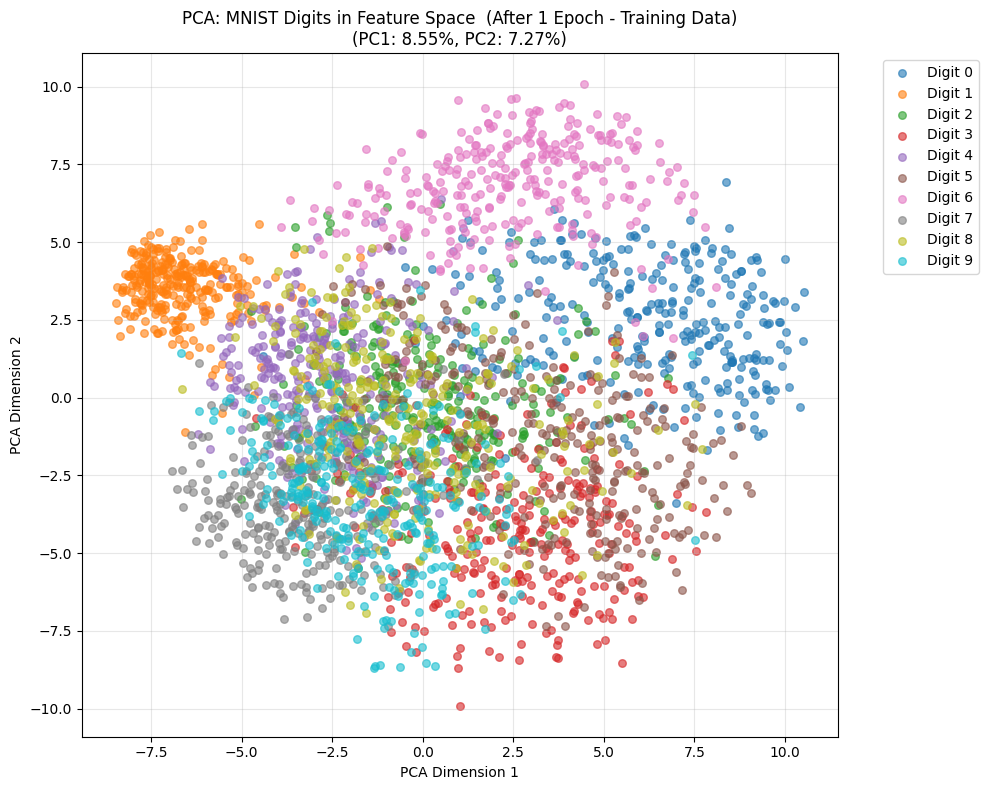

Computing t-SNE (this may take a while, be patient)...


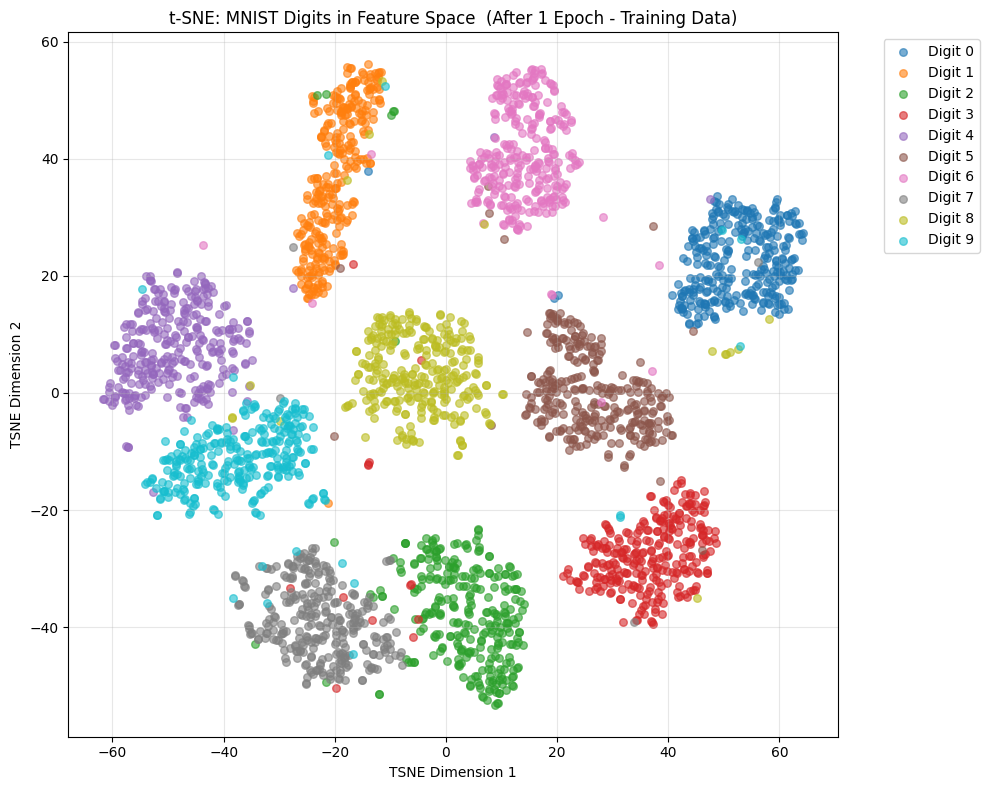


--- Evaluating Model on Test Set ---
Test Loss: 0.0386, Test Accuracy: 0.9900

--- Plotting Feature Space: Test Data ---
Extracting features from layer 'flatten_for_analysis'...


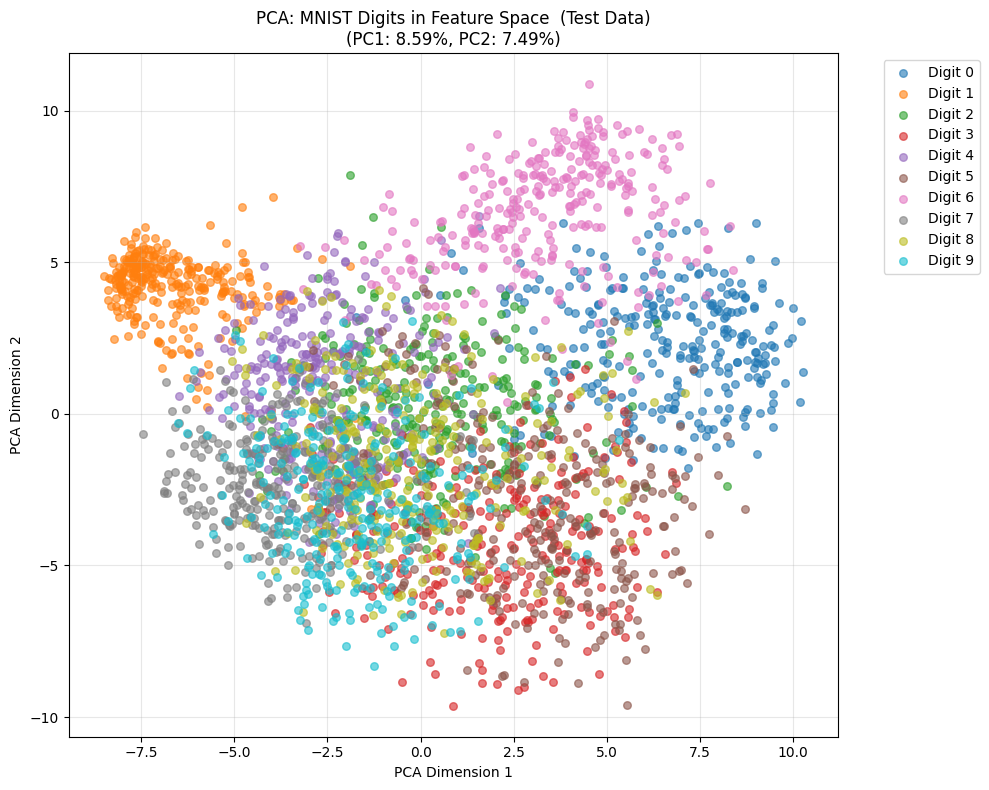

Computing t-SNE (this may take a while, be patient)...


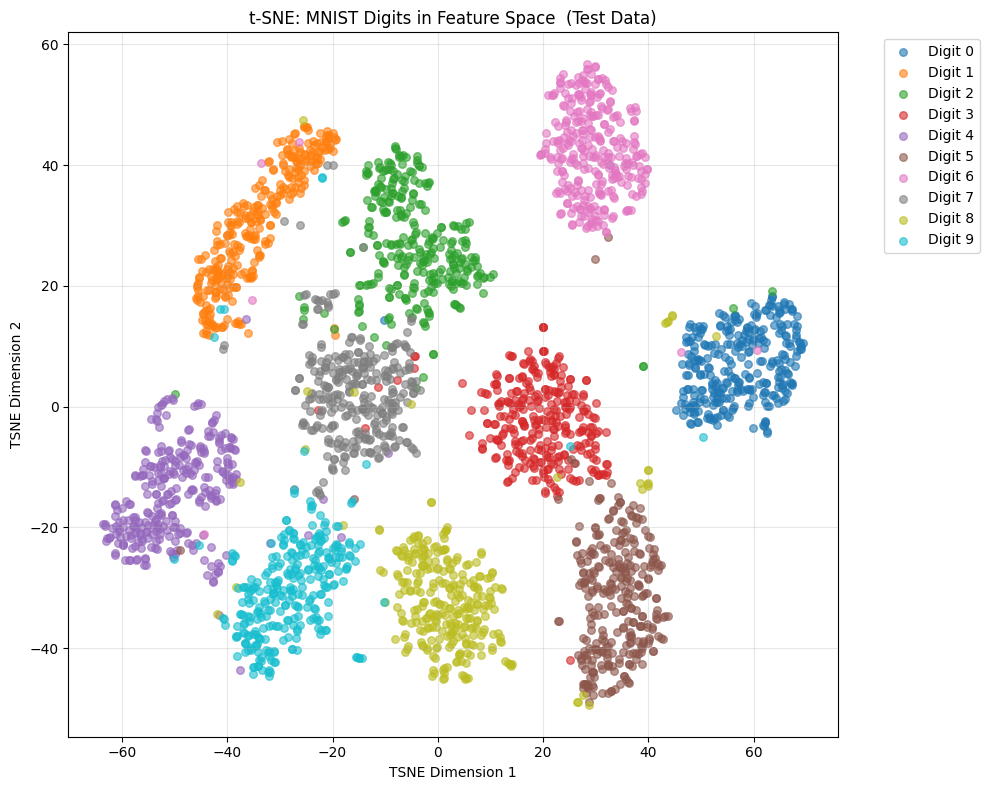

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import os # Keep for potential file operations if needed later, but not strictly used in this simplified version

# --- Simplified Feature Space Visualizer Class ---
class FeatureSpaceVisualizer:
    def __init__(self):
        """Initializes the visualizer, no VGG16 needed for this focused task."""
        print("FeatureSpaceVisualizer initialized.")

    def extract_features(self, model, images, layer_name='flatten_for_analysis', batch_size=32):
        """
        Extracts features from a specified layer of a given Keras model.
        Args:
            model: The Keras model to extract features from.
            images: Input images to process.
            layer_name: The name of the layer to extract features from.
            batch_size: Batch size for prediction.
        Returns:
            Numpy array of extracted features.
        """
        feature_extractor_model = Model(
            inputs=model.input,
            outputs=model.get_layer(layer_name).output
        )
        print(f"Extracting features from layer '{layer_name}'...")
        features = feature_extractor_model.predict(images, batch_size=batch_size, verbose=0)
        return features

    def visualize_feature_space(self, features, labels, title_suffix="", method='pca'):
        """
        Visualizes feature space using PCA or t-SNE.
        Args:
            features: The feature vectors (Numpy array).
            labels: The corresponding class labels (list or Numpy array of strings).
            title_suffix: Additional text for the plot title (e.g., "After 1 Epoch").
            method: 'pca' or 'tsne'.
        """
        plt.figure(figsize=(10, 8)) # Adjusted figure size for single plot

        unique_labels = sorted(list(set(labels)))
        # Use tab10 colormap, which has 10 distinct colors, perfect for MNIST
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
        label_to_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

        features_2d = None
        plot_title = ""

        if method.lower() == 'pca':
            pca = PCA(n_components=2)
            features_2d = pca.fit_transform(features)
            plot_title = f'PCA: MNIST Digits in Feature Space {title_suffix}\n' \
                         f'(PC1: {pca.explained_variance_ratio_[0]:.2%}, ' \
                         f'PC2: {pca.explained_variance_ratio_[1]:.2%})'

        elif method.lower() == 'tsne':
            print("Computing t-SNE (this may take a while, be patient)...")
            # Perplexity and n_iter are important t-SNE parameters.
            # Adjust perplexity based on dataset size (typically 5 to 50).
            # n_iter (iterations) affects convergence.
            tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
            features_2d = tsne.fit_transform(features)
            plot_title = f't-SNE: MNIST Digits in Feature Space {title_suffix}'
        else:
            print("Invalid method. Choose 'pca' or 'tsne'.")
            return

        if features_2d is not None:
            for i, digit in enumerate(unique_labels):
                mask = np.array(labels) == digit
                if np.any(mask): # Only plot if there are samples for this digit
                    plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                                c=[label_to_color_map[digit]], label=f'Digit {digit}',
                                alpha=0.6, s=30) # s is marker size

            plt.xlabel(f'{method.upper()} Dimension 1')
            plt.ylabel(f'{method.upper()} Dimension 2')
            plt.title(plot_title)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
            plt.grid(True, alpha=0.3)
            plt.tight_layout() # Adjust layout to prevent labels/titles overlapping
            plt.show()

# --- MNIST Model Trainer and Feature Space Plotter ---
class MNISTTrainerAndPlotter:
    def __init__(self):
        self.model = self._build_mnist_model()
        self.visualizer = FeatureSpaceVisualizer() # Use the simplified visualizer

    def _build_mnist_model(self):
        """Builds a simple CNN model for MNIST classification with a named flatten layer."""
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(name='flatten_for_analysis'), # The layer we'll extract features from
            Dense(128, activation='relu'),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        print("\n--- MNIST CNN Model Summary ---")
        model.summary()
        return model

    def load_and_preprocess_mnist_data(self, samples_per_digit=300):
        """
        Loads and preprocesses MNIST data, sampling a subset for feature analysis.
        Returns:
            Tuple of (full_train_data, full_test_data, sampled_train_data_for_analysis,
                      sampled_test_data_for_analysis, digit_classes_as_strings)
        """
        print("Loading MNIST dataset...")
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        # Full datasets for model training/evaluation
        x_train_full = x_train.astype('float32') / 255.0
        x_train_full = np.expand_dims(x_train_full, -1) # Add channel dim
        y_train_full = to_categorical(y_train, 10)

        x_test_full = x_test.astype('float32') / 255.0
        x_test_full = np.expand_dims(x_test_full, -1) # Add channel dim
        y_test_full = to_categorical(y_test, 10)

        # Sampled data for feature space plotting
        sampled_x_train = []
        sampled_y_train = []
        sampled_x_test = []
        sampled_y_test = []

        digit_classes_str = [str(i) for i in range(10)]

        for digit in range(10):
            # Training samples
            train_mask = y_train == digit
            train_images_digit = x_train_full[train_mask] # Already 28x28x1
            n_train_samples = min(samples_per_digit, len(train_images_digit))
            sampled_indices_train = np.random.choice(len(train_images_digit), n_train_samples, replace=False)
            sampled_x_train.extend(train_images_digit[sampled_indices_train])
            sampled_y_train.extend([str(digit)] * n_train_samples) # Labels as strings

            # Test samples
            test_mask = y_test == digit
            test_images_digit = x_test_full[test_mask] # Already 28x28x1
            n_test_samples = min(samples_per_digit, len(test_images_digit))
            sampled_indices_test = np.random.choice(len(test_images_digit), n_test_samples, replace=False)
            sampled_x_test.extend(test_images_digit[sampled_indices_test])
            sampled_y_test.extend([str(digit)] * n_test_samples) # Labels as strings

        print(f"Loaded and sampled {len(sampled_x_train)} training images and {len(sampled_x_test)} test images for analysis.")

        return (x_train_full, y_train_full,
                x_test_full, y_test_full,
                np.array(sampled_x_train), np.array(sampled_y_train),
                np.array(sampled_x_test), np.array(sampled_y_test),
                digit_classes_str)

    def run_pipeline(self):
        """Executes the training and feature space plotting pipeline."""
        (x_train_full, y_train_full,
         x_test_full, y_test_full,
         x_train_sampled, y_train_sampled,
         x_test_sampled, y_test_sampled,
         digit_classes_str) = self.load_and_preprocess_mnist_data()

        # --- Train MNIST Model for 1 Epoch ---
        print("\n--- Starting MNIST Model Training (1 Epoch) ---")
        self.model.fit(x_train_full, y_train_full, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
        print("Training complete for 1 epoch.")

        # --- Plot Feature Space After 1 Epoch (Training Data) ---
        print("\n--- Plotting Feature Space: After 1 Epoch (Training Data) ---")
        features_after_epoch1 = self.visualizer.extract_features(self.model, x_train_sampled)
        self.visualizer.visualize_feature_space(features_after_epoch1, y_train_sampled,
                                                title_suffix=" (After 1 Epoch - Training Data)", method='pca')
        self.visualizer.visualize_feature_space(features_after_epoch1, y_train_sampled,
                                                title_suffix=" (After 1 Epoch - Training Data)", method='tsne')

        # --- Evaluate Model on Test Set ---
        print("\n--- Evaluating Model on Test Set ---")
        loss, accuracy = self.model.evaluate(x_test_full, y_test_full, verbose=0)
        print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

        # --- Plot Feature Space on Test Data ---
        print("\n--- Plotting Feature Space: Test Data ---")
        features_test = self.visualizer.extract_features(self.model, x_test_sampled)
        self.visualizer.visualize_feature_space(features_test, y_test_sampled,
                                                title_suffix=" (Test Data)", method='pca')
        self.visualizer.visualize_feature_space(features_test, y_test_sampled,
                                                title_suffix=" (Test Data)", method='tsne')

# --- Main Execution Block ---
if __name__ == "__main__":
    trainer_plotter = MNISTTrainerAndPlotter()
    trainer_plotter.run_pipeline()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# --- Helper Functions for MNIST Model and Feature Extraction ---

def build_mnist_model():
    """Builds a simple CNN model for MNIST classification with a named flatten layer."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(name='flatten_for_analysis'), # The layer we'll extract features from
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("\n--- MNIST CNN Model Summary ---")
    model.summary()
    return model

def load_and_preprocess_mnist_data(samples_per_digit=300):
    """
    Loads and preprocesses MNIST data, sampling a subset for feature analysis.
    Returns:
        Tuple of (full_train_data, full_test_data, sampled_train_data_for_analysis,
                  sampled_test_data_for_analysis, digit_classes_as_strings)
    """
    print("Loading MNIST dataset...")
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Full datasets for model training/evaluation
    x_train_full = x_train.astype('float32') / 255.0
    x_train_full = np.expand_dims(x_train_full, -1) # Add channel dim
    y_train_full = to_categorical(y_train, 10)

    x_test_full = x_test.astype('float32') / 255.0
    x_test_full = np.expand_dims(x_test_full, -1) # Add channel dim
    y_test_full = to_categorical(y_test, 10)

    # Sampled data for feature space plotting
    sampled_x_train = []
    sampled_y_train = []
    sampled_x_test = []
    sampled_y_test = []

    digit_classes_str = [str(i) for i in range(10)]

    for digit in range(10):
        # Training samples
        train_mask = y_train == digit
        train_images_digit = x_train_full[train_mask] # Already 28x28x1
        n_train_samples = min(samples_per_digit, len(train_images_digit))
        sampled_indices_train = np.random.choice(len(train_images_digit), n_train_samples, replace=False)
        sampled_x_train.extend(train_images_digit[sampled_indices_train])
        sampled_y_train.extend([str(digit)] * n_train_samples) # Labels as strings

        # Test samples
        test_mask = y_test == digit
        test_images_digit = x_test_full[test_mask] # Already 28x28x1
        n_test_samples = min(samples_per_digit, len(test_images_digit))
        sampled_indices_test = np.random.choice(len(test_images_digit), n_test_samples, replace=False)
        sampled_x_test.extend(test_images_digit[sampled_indices_test])
        sampled_y_test.extend([str(digit)] * n_test_samples) # Labels as strings

    print(f"Loaded and sampled {len(sampled_x_train)} training images and {len(sampled_x_test)} test images for analysis.")

    return (x_train_full, y_train_full,
            x_test_full, y_test_full,
            np.array(sampled_x_train), np.array(sampled_y_train),
            np.array(sampled_x_test), np.array(sampled_y_test),
            digit_classes_str)

def extract_features(model, images, layer_name='flatten_for_analysis', batch_size=32):
    """
    Extracts features from a specified layer of a given Keras model.
    Args:
        model: The Keras model to extract features from.
        images: Input images to process.
        layer_name: The name of the layer to extract features from.
        batch_size: Batch size for prediction.
    Returns:
        Numpy array of extracted features.
    """
    feature_extractor_model = Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output
    )
    print(f"Extracting features from layer '{layer_name}'...")
    features = feature_extractor_model.predict(images, batch_size=batch_size, verbose=0)
    return features

def visualize_feature_space(features, labels, title_suffix="", method='pca'):
    """
    Visualizes feature space using PCA or t-SNE.
    Args:
        features: The feature vectors (Numpy array).
        labels: The corresponding class labels (list or Numpy array of strings).
        title_suffix: Additional text for the plot title (e.g., "After 1 Epoch").
        method: 'pca' or 'tsne'.
    """
    plt.figure(figsize=(10, 8)) # Adjusted figure size for single plot

    unique_labels = sorted(list(set(labels)))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    label_to_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    features_2d = None
    plot_title = ""

    if method.lower() == 'pca':
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features)
        plot_title = f'PCA: MNIST Digits in Feature Space {title_suffix}\n' \
                     f'(PC1: {pca.explained_variance_ratio_[0]:.2%}, ' \
                     f'PC2: {pca.explained_variance_ratio_[1]:.2%})'

    elif method.lower() == 'tsne':
        print("Computing t-SNE (this may take a while, be patient)...")
        # Perplexity and n_iter are important t-SNE parameters.
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        features_2d = tsne.fit_transform(features)
        plot_title = f't-SNE: MNIST Digits in Feature Space {title_suffix}'
    else:
        print("Invalid method. Choose 'pca' or 'tsne'.")
        return

    if features_2d is not None:
        for i, digit in enumerate(unique_labels):
            mask = np.array(labels) == digit
            if np.any(mask): # Only plot if there are samples for this digit
                plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                            c=[label_to_color_map[digit]], label=f'Digit {digit}',
                            alpha=0.6, s=30) # s is marker size

        plt.xlabel(f'{method.upper()} Dimension 1')
        plt.ylabel(f'{method.upper()} Dimension 2')
        plt.title(plot_title)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
        plt.grid(True, alpha=0.3)
        plt.tight_layout() # Adjust layout to prevent labels/titles overlapping
        plt.show()

# --- Main Execution Logic ---

def run_feature_space_pipeline():
    """Executes the training and feature space plotting pipeline."""

    # 1. Build the MNIST model
    model = build_mnist_model()

    # 2. Load and preprocess MNIST data
    (x_train_full, y_train_full,
     x_test_full, y_test_full,
     x_train_sampled, y_train_sampled,
     x_test_sampled, y_test_sampled,
     digit_classes_str) = load_and_preprocess_mnist_data()

    # 3. Train MNIST Model for 1 Epoch
    print("\n--- Starting MNIST Model Training (1 Epoch) ---")
    model.fit(x_train_full, y_train_full, epochs=1, batch_size=64, validation_split=0.1, verbose=1)
    print("Training complete for 1 epoch.")

    # 4. Plot Feature Space After 1 Epoch (Training Data)
    print("\n--- Plotting Feature Space: After 1 Epoch (Training Data) ---")
    features_after_epoch1 = extract_features(model, x_train_sampled)
    visualize_feature_space(features_after_epoch1, y_train_sampled,
                            title_suffix=" (After 1 Epoch - Training Data)", method='pca')
    visualize_feature_space(features_after_epoch1, y_train_sampled,
                            title_suffix=" (After 1 Epoch - Training Data)", method='tsne')

    # 5. Evaluate Model on Test Set
    print("\n--- Evaluating Model on Test Set ---")
    loss, accuracy = model.evaluate(x_test_full, y_test_full, verbose=0)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # 6. Plot Feature Space on Test Data
    print("\n--- Plotting Feature Space: Test Data ---")
    features_test = extract_features(model, x_test_sampled)
    visualize_feature_space(features_test, y_test_sampled,
                            title_suffix=" (Test Data)", method='pca')
    visualize_feature_space(features_test, y_test_sampled,
                            title_suffix=" (Test Data)", method='tsne')

# --- Main entry point ---
if __name__ == "__main__":
    run_feature_space_pipeline()


--- MNIST CNN Model Summary ---
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_for_analysis (Flat  (None, 1600)              0         
 ten)                                                            
                     

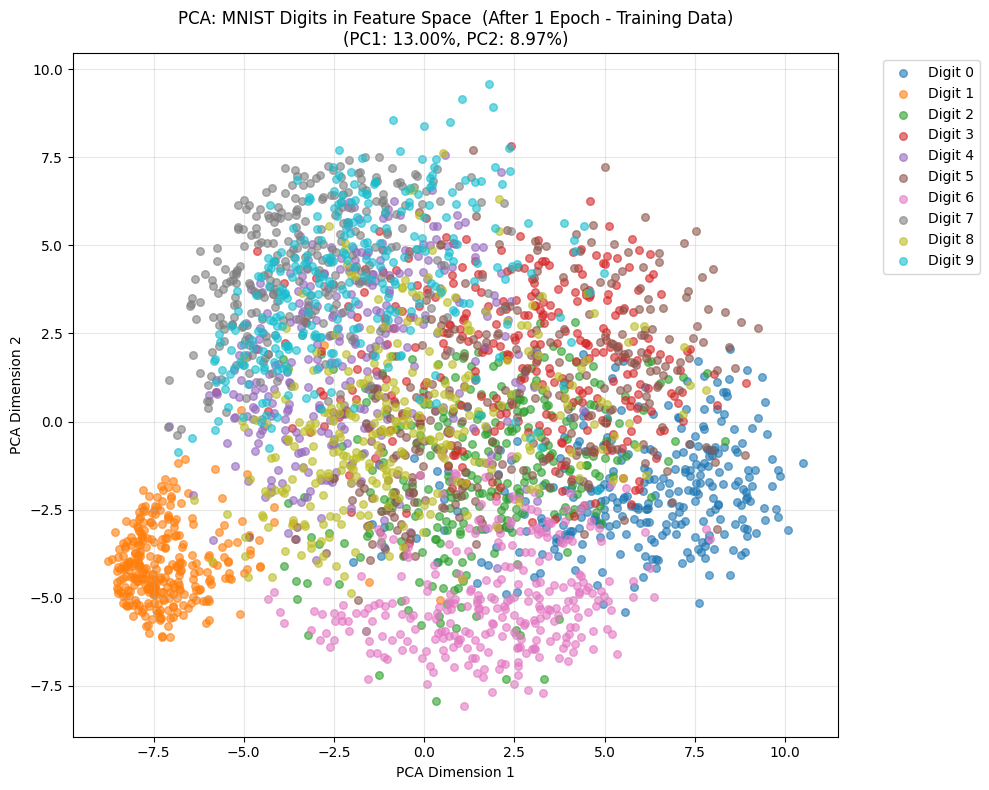

Computing t-SNE (this may take a while, be patient)...


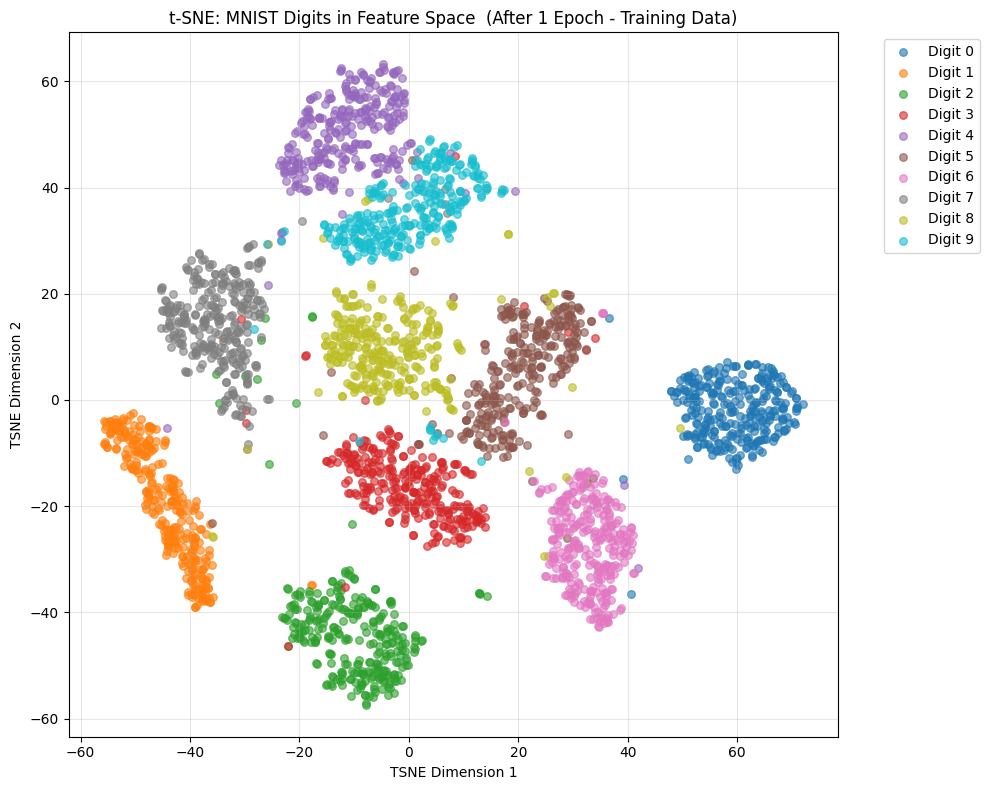


--- Evaluating Model on Test Set ---
Test Loss: 0.0550, Test Accuracy: 0.9829

--- Plotting Feature Space: Test Data ---
Extracting features from layer 'flatten_for_analysis'...


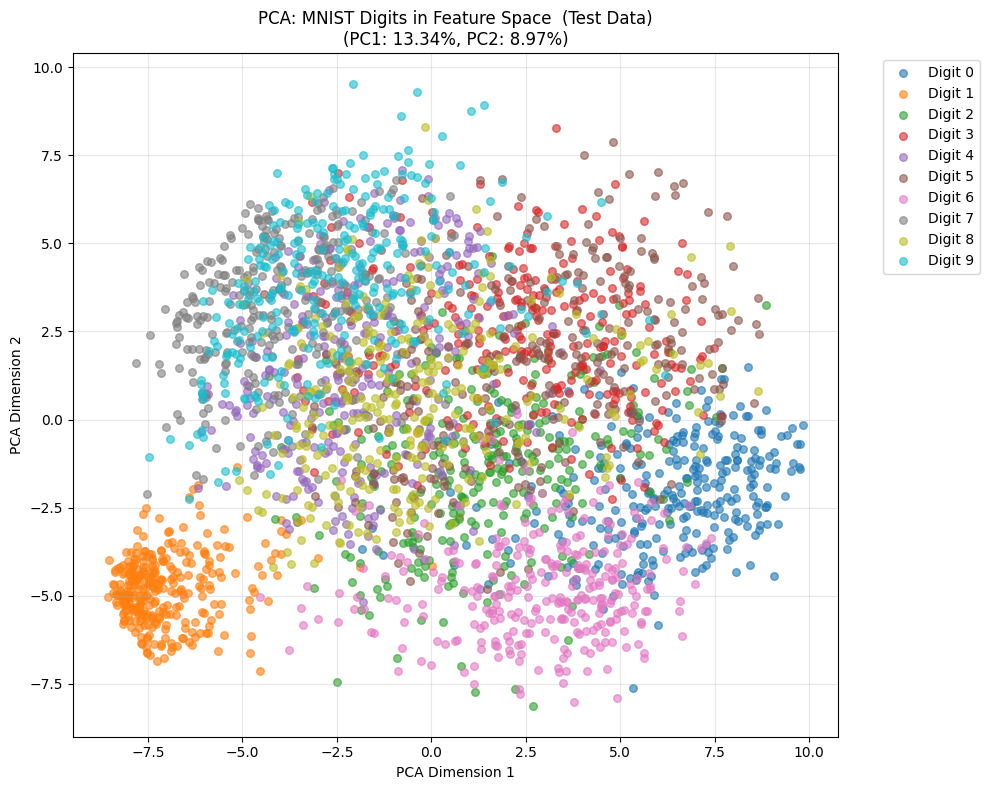

Computing t-SNE (this may take a while, be patient)...


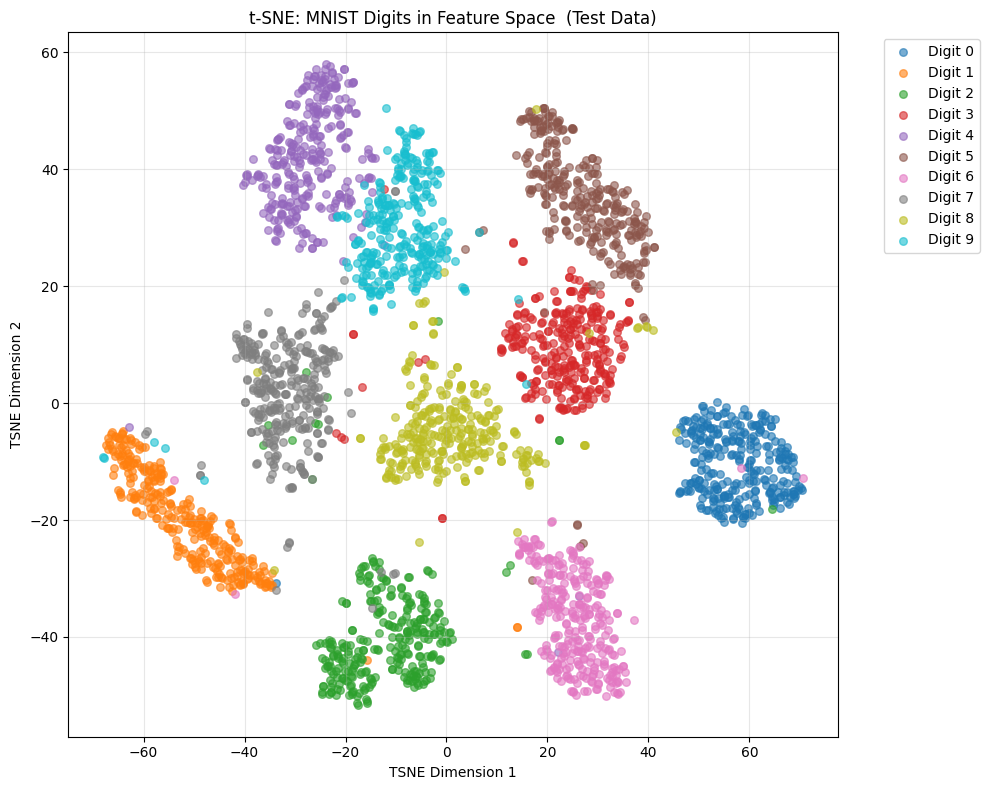

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

def build_mnist_model():
    """Builds a simple CNN model for MNIST classification with a named flatten layer."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(name='flatten_for_analysis'), # The layer we'll extract features from
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("\n--- MNIST CNN Model Summary ---")
    model.summary()
    return model

def load_and_preprocess_mnist_data(samples_per_digit=300):
    print("Loading MNIST dataset...")
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Full datasets for model training/evaluation
    x_train_full = x_train.astype('float32') / 255.0
    x_train_full = np.expand_dims(x_train_full, -1) # Add channel dim
    y_train_full = to_categorical(y_train, 10)

    x_test_full = x_test.astype('float32') / 255.0
    x_test_full = np.expand_dims(x_test_full, -1) # Add channel dim
    y_test_full = to_categorical(y_test, 10)

    # Sampled data for feature space plotting
    sampled_x_train = []
    sampled_y_train = []
    sampled_x_test = []
    sampled_y_test = []

    digit_classes_str = [str(i) for i in range(10)]

    for digit in range(10):
        # Training samples
        train_mask = y_train == digit
        train_images_digit = x_train_full[train_mask] # Already 28x28x1
        n_train_samples = min(samples_per_digit, len(train_images_digit))
        sampled_indices_train = np.random.choice(len(train_images_digit), n_train_samples, replace=False)
        sampled_x_train.extend(train_images_digit[sampled_indices_train])
        sampled_y_train.extend([str(digit)] * n_train_samples) # Labels as strings

        # Test samples
        test_mask = y_test == digit
        test_images_digit = x_test_full[test_mask] # Already 28x28x1
        n_test_samples = min(samples_per_digit, len(test_images_digit))
        sampled_indices_test = np.random.choice(len(test_images_digit), n_test_samples, replace=False)
        sampled_x_test.extend(test_images_digit[sampled_indices_test])
        sampled_y_test.extend([str(digit)] * n_test_samples) # Labels as strings

    print(f"Loaded and sampled {len(sampled_x_train)} training images and {len(sampled_x_test)} test images for analysis.")

    return (x_train_full, y_train_full,
            x_test_full, y_test_full,
            np.array(sampled_x_train), np.array(sampled_y_train),
            np.array(sampled_x_test), np.array(sampled_y_test),
            digit_classes_str)

def extract_features(model, images, layer_name='flatten_for_analysis', batch_size=32):
    feature_extractor_model = Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output
    )
    print(f"Extracting features from layer '{layer_name}'...")
    features = feature_extractor_model.predict(images, batch_size=batch_size, verbose=0)
    return features

def visualize_feature_space(features, labels, title_suffix="", method='pca'):
    plt.figure(figsize=(10, 8)) # Adjusted figure size for single plot

    unique_labels = sorted(list(set(labels)))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    label_to_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    features_2d = None
    plot_title = ""

    if method.lower() == 'pca':
        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features)
        plot_title = f'PCA: MNIST Digits in Feature Space {title_suffix}\n' \
                     f'(PC1: {pca.explained_variance_ratio_[0]:.2%}, ' \
                     f'PC2: {pca.explained_variance_ratio_[1]:.2%})'

    elif method.lower() == 'tsne':
        print("Computing t-SNE (this may take a while, be patient)...")
        # Perplexity and n_iter are important t-SNE parameters.
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        features_2d = tsne.fit_transform(features)
        plot_title = f't-SNE: MNIST Digits in Feature Space {title_suffix}'
    else:
        print("Invalid method. Choose 'pca' or 'tsne'.")
        return

    if features_2d is not None:
        for i, digit in enumerate(unique_labels):
            mask = np.array(labels) == digit
            if np.any(mask): # Only plot if there are samples for this digit
                plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                            c=[label_to_color_map[digit]], label=f'Digit {digit}',
                            alpha=0.6, s=30) # s is marker size

        plt.xlabel(f'{method.upper()} Dimension 1')
        plt.ylabel(f'{method.upper()} Dimension 2')
        plt.title(plot_title)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
        plt.grid(True, alpha=0.3)
        plt.tight_layout() # Adjust layout to prevent labels/titles overlapping
        plt.show()

def run_feature_space_pipeline():
    """Executes the training and feature space plotting pipeline."""

    # 1. Build the MNIST model
    model = build_mnist_model()

    # 2. Load and preprocess MNIST data
    (x_train_full, y_train_full,
     x_test_full, y_test_full,
     x_train_sampled, y_train_sampled,
     x_test_sampled, y_test_sampled,
     digit_classes_str) = load_and_preprocess_mnist_data()

    # 3. Train MNIST Model for 1 Epoch
    print("\n--- Starting MNIST Model Training (1 Epoch) ---")
    model.fit(x_train_full, y_train_full, epochs=1, batch_size=64, validation_split=0.1, verbose=1)
    print("Training complete for 1 epoch.")

    # 4. Plot Feature Space After 1 Epoch (Training Data)
    print("\n--- Plotting Feature Space: After 1 Epoch (Training Data) ---")
    features_after_epoch1 = extract_features(model, x_train_sampled)
    visualize_feature_space(features_after_epoch1, y_train_sampled,
                            title_suffix=" (After 1 Epoch - Training Data)", method='pca')
    visualize_feature_space(features_after_epoch1, y_train_sampled,
                            title_suffix=" (After 1 Epoch - Training Data)", method='tsne')

    # 5. Evaluate Model on Test Set
    print("\n--- Evaluating Model on Test Set ---")
    loss, accuracy = model.evaluate(x_test_full, y_test_full, verbose=0)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # 6. Plot Feature Space on Test Data
    print("\n--- Plotting Feature Space: Test Data ---")
    features_test = extract_features(model, x_test_sampled)
    visualize_feature_space(features_test, y_test_sampled,
                            title_suffix=" (Test Data)", method='pca')
    visualize_feature_space(features_test, y_test_sampled,
                            title_suffix=" (Test Data)", method='tsne')
if __name__ == "__main__":
    run_feature_space_pipeline()